In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import quandl
import cvxpy as cvx

In [3]:
sys.path.insert(0, os.path.abspath('..'))
import helium

In [4]:
%matplotlib inline

In [5]:
quandl.ApiConfig.api_key = '8wnB7EcvJm1xEvJjzWBR'

In [6]:
tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["_CASH"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,NKE,TSLA,_CASH
Date,,,,,
2016-12-23,-0.007503,-0.002322,-0.004411,0.023459,0.000020
2016-12-27,0.014213,0.002637,-0.011944,0.029015,0.000020
2016-12-28,0.000946,-0.006618,-0.005264,0.000957,0.000021
2016-12-29,-0.009040,-0.002101,0.000784,-0.023027,0.000018
2016-12-30,-0.019970,-0.012991,-0.004505,-0.004612,0.000020


In [7]:
rets = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
sigmas = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna()
rets.tail()

,AMZN,GOOGL,NKE,TSLA,_CASH
Date,,,,,
2016-12-23,0.000683,0.000219,-0.000660,-0.000074,0.000012
2016-12-27,0.000542,0.000150,-0.000706,-0.000124,0.000013
2016-12-28,0.000627,0.000179,-0.000691,-0.000023,0.000013
2016-12-29,0.000707,0.000215,-0.000664,-0.000052,0.000013
2016-12-30,0.000901,0.000302,-0.000598,0.000133,0.000013


In [8]:
cash_ticker = "_CASH"

In [9]:
price_sigma = rets.copy()
price_sigma[:] = 0.

In [10]:
volumes = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Volume'])
                for ticker in tickers]))
volumes[cash_ticker] = np.finfo(np.float).max

In [11]:
tcost_model=helium.TransactionCost(gamma = 1., 
                                   half_spread=10E-4,
                                   nonlin_coef = 0.,  #1.,
                                   sigmas = price_sigma, 
                                   nonlin_power = 1.5,
                                   volumes = volumes,
                                   asym_coef = 0.)

In [12]:
borrow_costs = rets.copy()
borrow_costs[:] = 1E-4
borrow_costs["_CASH"] = 0.

dividends = rets.copy()
dividends[:] = 0.


hcost_model=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)

In [13]:
risk_model = helium.BasicRiskCost(5.0, sigmas)

In [14]:
leverage_limit = helium.LeverageLimitConstraint(3.)

In [15]:
holding_init = pd.Series(index=rets.columns, data=0.)
holding_init[cash_ticker] = 100.
holding_init

holding_init = pd.Series(index=rets.columns, data=250000.)
holding_init[cash_ticker] = 0.
holding_init

AMZN     250000.0
GOOGL    250000.0
NKE      250000.0
TSLA     250000.0
_CASH         0.0
dtype: float64

In [16]:
deltas = rets.copy()
deltas[:]  = 0.

In [17]:
r = helium.DefaultRet(rets=rets, deltas = deltas, gamma_decay=None)

In [18]:
spo_policy = helium.SinglePeriodOpt(rets=r,
                                   costs=[risk_model, hcost_model, tcost_model],
                                   constraints=[leverage_limit]
                                   )

In [19]:
simulator = helium.MarketSimulator(returns, volumes, costs=[hcost_model, tcost_model], cash_ticker='_CASH')

In [24]:
result = simulator.run(holding_init, policy=spo_policy, start_date='2014-01-03', end_date='2016-12-31')

INFO:root:Backtest started, from 2014-01-03 00:00:00 to 2016-12-30 00:00:00
INFO:root:Getting trades at date: 2014-01-03 00:00:00
INFO:root:Propagating portfolio at time 2014-01-03 00:00:00
INFO:root:Getting trades at date: 2014-01-06 00:00:00
INFO:root:Propagating portfolio at time 2014-01-06 00:00:00
INFO:root:Getting trades at date: 2014-01-07 00:00:00
INFO:root:Propagating portfolio at time 2014-01-07 00:00:00
INFO:root:Getting trades at date: 2014-01-08 00:00:00
INFO:root:Propagating portfolio at time 2014-01-08 00:00:00
INFO:root:Getting trades at date: 2014-01-09 00:00:00
INFO:root:Propagating portfolio at time 2014-01-09 00:00:00
INFO:root:Getting trades at date: 2014-01-10 00:00:00
INFO:root:Propagating portfolio at time 2014-01-10 00:00:00
INFO:root:Getting trades at date: 2014-01-13 00:00:00
INFO:root:Propagating portfolio at time 2014-01-13 00:00:00
INFO:root:Getting trades at date: 2014-01-14 00:00:00
INFO:root:Propagating portfolio at time 2014-01-14 00:00:00
INFO:root:Ge

INFO:root:Propagating portfolio at time 2014-04-16 00:00:00
INFO:root:Getting trades at date: 2014-04-17 00:00:00
INFO:root:Propagating portfolio at time 2014-04-17 00:00:00
INFO:root:Getting trades at date: 2014-04-21 00:00:00
INFO:root:Propagating portfolio at time 2014-04-21 00:00:00
INFO:root:Getting trades at date: 2014-04-22 00:00:00
INFO:root:Propagating portfolio at time 2014-04-22 00:00:00
INFO:root:Getting trades at date: 2014-04-23 00:00:00
INFO:root:Propagating portfolio at time 2014-04-23 00:00:00
INFO:root:Getting trades at date: 2014-04-24 00:00:00
INFO:root:Propagating portfolio at time 2014-04-24 00:00:00
INFO:root:Getting trades at date: 2014-04-25 00:00:00
INFO:root:Propagating portfolio at time 2014-04-25 00:00:00
INFO:root:Getting trades at date: 2014-04-28 00:00:00
INFO:root:Propagating portfolio at time 2014-04-28 00:00:00
INFO:root:Getting trades at date: 2014-04-29 00:00:00
INFO:root:Propagating portfolio at time 2014-04-29 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-07-30 00:00:00
INFO:root:Getting trades at date: 2014-07-31 00:00:00
INFO:root:Propagating portfolio at time 2014-07-31 00:00:00
INFO:root:Getting trades at date: 2014-08-01 00:00:00
INFO:root:Propagating portfolio at time 2014-08-01 00:00:00
INFO:root:Getting trades at date: 2014-08-04 00:00:00
INFO:root:Propagating portfolio at time 2014-08-04 00:00:00
INFO:root:Getting trades at date: 2014-08-05 00:00:00
INFO:root:Propagating portfolio at time 2014-08-05 00:00:00
INFO:root:Getting trades at date: 2014-08-06 00:00:00
INFO:root:Propagating portfolio at time 2014-08-06 00:00:00
INFO:root:Getting trades at date: 2014-08-07 00:00:00
INFO:root:Propagating portfolio at time 2014-08-07 00:00:00
INFO:root:Getting trades at date: 2014-08-08 00:00:00
INFO:root:Propagating portfolio at time 2014-08-08 00:00:00
INFO:root:Getting trades at date: 2014-08-11 00:00:00
INFO:root:Propagating portfolio at time 2014-08-11 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-11-10 00:00:00
INFO:root:Getting trades at date: 2014-11-11 00:00:00
INFO:root:Propagating portfolio at time 2014-11-11 00:00:00
INFO:root:Getting trades at date: 2014-11-12 00:00:00
INFO:root:Propagating portfolio at time 2014-11-12 00:00:00
INFO:root:Getting trades at date: 2014-11-13 00:00:00
INFO:root:Propagating portfolio at time 2014-11-13 00:00:00
INFO:root:Getting trades at date: 2014-11-14 00:00:00
INFO:root:Propagating portfolio at time 2014-11-14 00:00:00
INFO:root:Getting trades at date: 2014-11-17 00:00:00
INFO:root:Propagating portfolio at time 2014-11-17 00:00:00
INFO:root:Getting trades at date: 2014-11-18 00:00:00
INFO:root:Propagating portfolio at time 2014-11-18 00:00:00
INFO:root:Getting trades at date: 2014-11-19 00:00:00
INFO:root:Propagating portfolio at time 2014-11-19 00:00:00
INFO:root:Getting trades at date: 2014-11-20 00:00:00
INFO:root:Propagating portfolio at time 2014-11-20 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-02-25 00:00:00
INFO:root:Getting trades at date: 2015-02-26 00:00:00
INFO:root:Propagating portfolio at time 2015-02-26 00:00:00
INFO:root:Getting trades at date: 2015-02-27 00:00:00
INFO:root:Propagating portfolio at time 2015-02-27 00:00:00
INFO:root:Getting trades at date: 2015-03-02 00:00:00
INFO:root:Propagating portfolio at time 2015-03-02 00:00:00
INFO:root:Getting trades at date: 2015-03-03 00:00:00
INFO:root:Propagating portfolio at time 2015-03-03 00:00:00
INFO:root:Getting trades at date: 2015-03-04 00:00:00
INFO:root:Propagating portfolio at time 2015-03-04 00:00:00
INFO:root:Getting trades at date: 2015-03-05 00:00:00
INFO:root:Propagating portfolio at time 2015-03-05 00:00:00
INFO:root:Getting trades at date: 2015-03-06 00:00:00
INFO:root:Propagating portfolio at time 2015-03-06 00:00:00
INFO:root:Getting trades at date: 2015-03-09 00:00:00
INFO:root:Propagating portfolio at time 2015-03-09 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2015-06-09 00:00:00
INFO:root:Propagating portfolio at time 2015-06-09 00:00:00
INFO:root:Getting trades at date: 2015-06-10 00:00:00
INFO:root:Propagating portfolio at time 2015-06-10 00:00:00
INFO:root:Getting trades at date: 2015-06-11 00:00:00
INFO:root:Propagating portfolio at time 2015-06-11 00:00:00
INFO:root:Getting trades at date: 2015-06-12 00:00:00
INFO:root:Propagating portfolio at time 2015-06-12 00:00:00
INFO:root:Getting trades at date: 2015-06-15 00:00:00
INFO:root:Propagating portfolio at time 2015-06-15 00:00:00
INFO:root:Getting trades at date: 2015-06-16 00:00:00
INFO:root:Propagating portfolio at time 2015-06-16 00:00:00
INFO:root:Getting trades at date: 2015-06-17 00:00:00
INFO:root:Propagating portfolio at time 2015-06-17 00:00:00
INFO:root:Getting trades at date: 2015-06-18 00:00:00
INFO:root:Propagating portfolio at time 2015-06-18 00:00:00
INFO:root:Getting trades at date: 2015-06-19 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2015-09-18 00:00:00
INFO:root:Getting trades at date: 2015-09-21 00:00:00
INFO:root:Propagating portfolio at time 2015-09-21 00:00:00
INFO:root:Getting trades at date: 2015-09-22 00:00:00
INFO:root:Propagating portfolio at time 2015-09-22 00:00:00
INFO:root:Getting trades at date: 2015-09-23 00:00:00
INFO:root:Propagating portfolio at time 2015-09-23 00:00:00
INFO:root:Getting trades at date: 2015-09-24 00:00:00
INFO:root:Propagating portfolio at time 2015-09-24 00:00:00
INFO:root:Getting trades at date: 2015-09-25 00:00:00
INFO:root:Propagating portfolio at time 2015-09-25 00:00:00
INFO:root:Getting trades at date: 2015-09-28 00:00:00
INFO:root:Propagating portfolio at time 2015-09-28 00:00:00
INFO:root:Getting trades at date: 2015-09-29 00:00:00
INFO:root:Propagating portfolio at time 2015-09-29 00:00:00
INFO:root:Getting trades at date: 2015-09-30 00:00:00
INFO:root:Propagating portfolio at time 2015-09-30 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-12-31 00:00:00
INFO:root:Getting trades at date: 2016-01-04 00:00:00
INFO:root:Propagating portfolio at time 2016-01-04 00:00:00
INFO:root:Getting trades at date: 2016-01-05 00:00:00
INFO:root:Propagating portfolio at time 2016-01-05 00:00:00
INFO:root:Getting trades at date: 2016-01-06 00:00:00
INFO:root:Propagating portfolio at time 2016-01-06 00:00:00
INFO:root:Getting trades at date: 2016-01-07 00:00:00
INFO:root:Propagating portfolio at time 2016-01-07 00:00:00
INFO:root:Getting trades at date: 2016-01-08 00:00:00
INFO:root:Propagating portfolio at time 2016-01-08 00:00:00
INFO:root:Getting trades at date: 2016-01-11 00:00:00
INFO:root:Propagating portfolio at time 2016-01-11 00:00:00
INFO:root:Getting trades at date: 2016-01-12 00:00:00
INFO:root:Propagating portfolio at time 2016-01-12 00:00:00
INFO:root:Getting trades at date: 2016-01-13 00:00:00
INFO:root:Propagating portfolio at time 2016-01-13 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-04-15 00:00:00
INFO:root:Getting trades at date: 2016-04-18 00:00:00
INFO:root:Propagating portfolio at time 2016-04-18 00:00:00
INFO:root:Getting trades at date: 2016-04-19 00:00:00
INFO:root:Propagating portfolio at time 2016-04-19 00:00:00
INFO:root:Getting trades at date: 2016-04-20 00:00:00
INFO:root:Propagating portfolio at time 2016-04-20 00:00:00
INFO:root:Getting trades at date: 2016-04-21 00:00:00
INFO:root:Propagating portfolio at time 2016-04-21 00:00:00
INFO:root:Getting trades at date: 2016-04-22 00:00:00
INFO:root:Propagating portfolio at time 2016-04-22 00:00:00
INFO:root:Getting trades at date: 2016-04-25 00:00:00
INFO:root:Propagating portfolio at time 2016-04-25 00:00:00
INFO:root:Getting trades at date: 2016-04-26 00:00:00
INFO:root:Propagating portfolio at time 2016-04-26 00:00:00
INFO:root:Getting trades at date: 2016-04-27 00:00:00
INFO:root:Propagating portfolio at time 2016-04-27 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-07-28 00:00:00
INFO:root:Getting trades at date: 2016-07-29 00:00:00
INFO:root:Propagating portfolio at time 2016-07-29 00:00:00
INFO:root:Getting trades at date: 2016-08-01 00:00:00
INFO:root:Propagating portfolio at time 2016-08-01 00:00:00
INFO:root:Getting trades at date: 2016-08-02 00:00:00
INFO:root:Propagating portfolio at time 2016-08-02 00:00:00
INFO:root:Getting trades at date: 2016-08-03 00:00:00
INFO:root:Propagating portfolio at time 2016-08-03 00:00:00
INFO:root:Getting trades at date: 2016-08-04 00:00:00
INFO:root:Propagating portfolio at time 2016-08-04 00:00:00
INFO:root:Getting trades at date: 2016-08-05 00:00:00
INFO:root:Propagating portfolio at time 2016-08-05 00:00:00
INFO:root:Getting trades at date: 2016-08-08 00:00:00
INFO:root:Propagating portfolio at time 2016-08-08 00:00:00
INFO:root:Getting trades at date: 2016-08-09 00:00:00
INFO:root:Propagating portfolio at time 2016-08-09 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-11-08 00:00:00
INFO:root:Getting trades at date: 2016-11-09 00:00:00
INFO:root:Propagating portfolio at time 2016-11-09 00:00:00
INFO:root:Getting trades at date: 2016-11-10 00:00:00
INFO:root:Propagating portfolio at time 2016-11-10 00:00:00
INFO:root:Getting trades at date: 2016-11-11 00:00:00
INFO:root:Propagating portfolio at time 2016-11-11 00:00:00
INFO:root:Getting trades at date: 2016-11-14 00:00:00
INFO:root:Propagating portfolio at time 2016-11-14 00:00:00
INFO:root:Getting trades at date: 2016-11-15 00:00:00
INFO:root:Propagating portfolio at time 2016-11-15 00:00:00
INFO:root:Getting trades at date: 2016-11-16 00:00:00
INFO:root:Propagating portfolio at time 2016-11-16 00:00:00
INFO:root:Getting trades at date: 2016-11-17 00:00:00
INFO:root:Propagating portfolio at time 2016-11-17 00:00:00
INFO:root:Getting trades at date: 2016-11-18 00:00:00
INFO:root:Propagating portfolio at time 2016-11-18 00:00:00
INFO:root:Getting trades at 

In [25]:
result.summary()

Number of periods                       755
Initial timestamp       2014-01-03 00:00:00
Final timestamp         2016-12-30 00:00:00
Portfolio return (%)                  8.816
Excess return (%)                     8.681
Excess risk (%)                      18.424
Sharpe ratio                          0.472
Max. drawdown                        20.011
Turnover (%)                         94.748


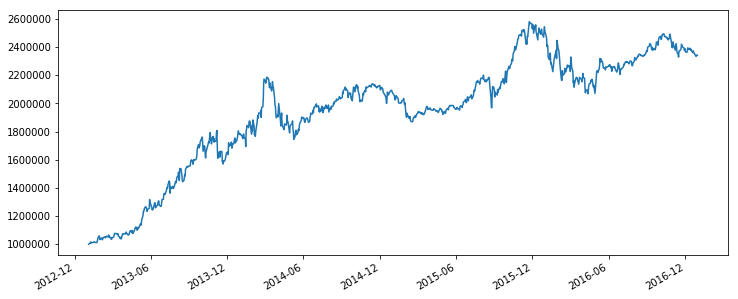

In [22]:
result.v.plot(figsize=(12,5))

/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe0a89b8f98> has a label of '_CASH' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


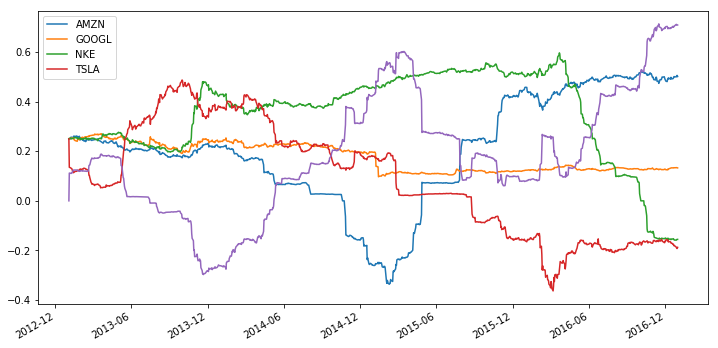

In [23]:
result.w.plot(figsize=(12,6))